# Hands-on Machine learning

## Chapter 2: Selected exercises

The following code picks out the most relevant scripts from the chapter to get the data into the environment,cleaned, and transformed to answer some of the exercises. Still a work in progress so there may be errors!Exercises start after cell 20 or so.

### Data preparation

In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
housing = pd.read_csv("datasets/housing/housing.csv")
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


#### Exploratory data analysis to adjust unbalanced data

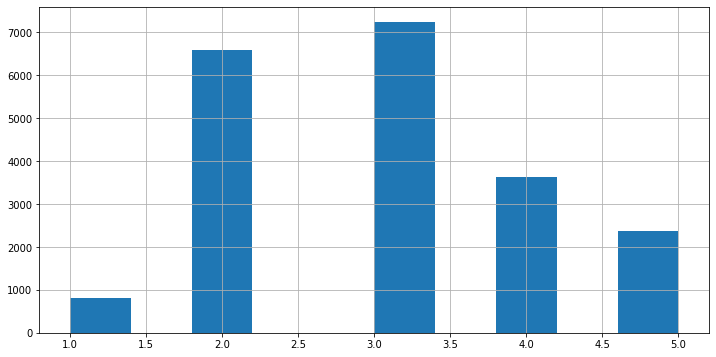

Median income is not split evenly


In [3]:
housing['income_cat'] = pd.cut(housing['median_income'], bins=[0., 1.5, 3.0, 4.5, 6., np.inf], labels = [1,2,3,4,5])
housing['income_cat'].hist(figsize=(12,6))
plt.show()
print("Median income is not split evenly")

In [4]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=.2, random_state=42)
for train_index, test_index in split.split(housing, housing['income_cat']):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]

In [5]:
for set_ in (strat_train_set, strat_test_set):
    set_.drop('income_cat', axis=1, inplace=True)

In [6]:
housing = strat_train_set.copy().drop('median_house_value', axis=1)
housing_labels = strat_train_set['median_house_value'].copy()
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
17606,-121.89,37.29,38.0,1568.0,351.0,710.0,339.0,2.7042,<1H OCEAN
18632,-121.93,37.05,14.0,679.0,108.0,306.0,113.0,6.4214,<1H OCEAN
14650,-117.20,32.77,31.0,1952.0,471.0,936.0,462.0,2.8621,NEAR OCEAN
3230,-119.61,36.31,25.0,1847.0,371.0,1460.0,353.0,1.8839,INLAND
3555,-118.59,34.23,17.0,6592.0,1525.0,4459.0,1463.0,3.0347,<1H OCEAN


#### Data transformation through Pipeline

In [7]:
from sklearn.base import BaseEstimator, TransformerMixin

rooms_ix, bedrooms_ix, population_ix, households_ix = 3, 4, 5, 6

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room=True):
        self.add_bedrooms_per_room = add_bedrooms_per_room
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        rooms_per_household = X[:, rooms_ix] / X[:, households_ix]
        population_per_household = X[:, population_ix]/X[:, households_ix]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_ix]/X[:, rooms_ix]
            return np.c_[X, rooms_per_household, population_per_household, bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_household, population_per_household]

# attr_adder = CombinedAttributesAdder(add_bedrooms_per_room=False)
# housing_extra_attribs = attr_adder.transform(housing.values)

In [8]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer

num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('attribs_adder', CombinedAttributesAdder()),
    ('std_scaler', StandardScaler())
])

num_attribs = [x for x in list(housing.columns) if x not in 'ocean_proximity']
cat_attribs = ['ocean_proximity']

full_pipeline = ColumnTransformer([
    ('num', num_pipeline, num_attribs),
    ('cat', OneHotEncoder(), cat_attribs)
])

housing_prepared = full_pipeline.fit_transform(housing)

In [9]:
housing_prepared[:5]

array([[-1.15604281,  0.77194962,  0.74333089, -0.49323393, -0.44543821,
        -0.63621141, -0.42069842, -0.61493744, -0.31205452, -0.08649871,
         0.15531753,  1.        ,  0.        ,  0.        ,  0.        ,
         0.        ],
       [-1.17602483,  0.6596948 , -1.1653172 , -0.90896655, -1.0369278 ,
        -0.99833135, -1.02222705,  1.33645936,  0.21768338, -0.03353391,
        -0.83628902,  1.        ,  0.        ,  0.        ,  0.        ,
         0.        ],
       [ 1.18684903, -1.34218285,  0.18664186, -0.31365989, -0.15334458,
        -0.43363936, -0.0933178 , -0.5320456 , -0.46531516, -0.09240499,
         0.4222004 ,  0.        ,  0.        ,  0.        ,  0.        ,
         1.        ],
       [-0.01706767,  0.31357576, -0.29052016, -0.36276217, -0.39675594,
         0.03604096, -0.38343559, -1.04556555, -0.07966124,  0.08973561,
        -0.19645314,  0.        ,  1.        ,  0.        ,  0.        ,
         0.        ],
       [ 0.49247384, -0.65929936, -0

### Model training

#### Linear regression

In [11]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

lin_reg = LinearRegression()
lin_reg.fit(housing_prepared, housing_labels)
lin_reg_pred = lin_reg.predict(housing_prepared)

lin_reg_rmse = np.sqrt(mean_squared_error(housing_labels, lin_reg_pred))
print(f'Linear regression RMSE: {lin_reg_rmse:0.02f}')

Linear regression RMSE: 68628.20


#### Random forest

In [12]:
# Remove future warning on random forest
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Proceed
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor()
rf.fit(housing_prepared, housing_labels)
rf_pred = rf.predict(housing_prepared)

rf_rmse = np.sqrt(mean_squared_error(housing_labels, rf_pred))
print(f'Random forest RMSE: {rf_rmse:0.02f}')

Random forest RMSE: 22296.56


##### Cross-validation

In [13]:
from sklearn.model_selection import cross_val_score
models = [lin_reg, rf]

scores = []
for model in models:
    score = cross_val_score(model, housing_prepared, housing_labels, cv = 10, scoring = 'neg_mean_squared_error')
    rmse = np.sqrt(-score)
    scores.append(rmse.mean())

print(f'Cross-validated RMSE: linear regression: {scores[0]:0.04f} vs. random forest: {scores[1]:0.04f}')

Cross-validated RMSE: linear regression: 69052.4614 vs. random forest: 52803.6392


Random forest performs better than linear regression. But it is likely overfitting the data based on the\
RMSE deterioration after cross-validation 

### Model tuning

#### Grid search

In [14]:
from sklearn.model_selection import GridSearchCV

param_grid = [
    {'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]},
    {'bootstrap': [False], 'n_estimators': [3,10], 'max_features': [2, 3, 4]}
]

grid_search = GridSearchCV(rf, param_grid, cv=5,
                          scoring = 'neg_mean_squared_error',
                          return_train_score=True)

grid_search.fit(housing_prepared, housing_labels)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=RandomForestRegressor(bootstrap=True, criterion='mse',
                                             max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=10, n_jobs=None,
                                             oob_score=False, random_state=None,
                                             verbose=0, warm_start=False),
             iid='warn', n_jobs=None,
             param_grid=[{'max_features': [2, 4, 6, 8],
    

In [15]:
# The best parameters and the best esimtator
print(f'Best parameters: {grid_search.best_params_}')
print(f'Best estimators: {grid_search.best_estimator_}')

Best parameters: {'max_features': 8, 'n_estimators': 30}
Best estimators: RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features=8, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=30,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)


NB: max_features is the number of features to consider when assigning a branch (splitting a node). n_estimatros is the number of trees. 

In [16]:
# Examine the results of the grid search
# 18 results: 3x4 for first max_features/n_estimators combo + 2x6 for second 
cvres = grid_search.cv_results_
for mean_score, params in sorted(zip(cvres["mean_test_score"], cvres["params"]), reverse=True):
    print(np.sqrt(-mean_score), params)

49941.31016131014 {'max_features': 8, 'n_estimators': 30}
50058.544531016196 {'max_features': 6, 'n_estimators': 30}
50491.08462909935 {'max_features': 4, 'n_estimators': 30}
51893.64497519623 {'bootstrap': False, 'max_features': 4, 'n_estimators': 10}
52008.75059995632 {'max_features': 8, 'n_estimators': 10}
52592.575474430574 {'bootstrap': False, 'max_features': 3, 'n_estimators': 10}
52744.222696847886 {'max_features': 6, 'n_estimators': 10}
52891.13584691384 {'max_features': 2, 'n_estimators': 30}
52940.493029401296 {'max_features': 4, 'n_estimators': 10}
54732.1193350129 {'bootstrap': False, 'max_features': 2, 'n_estimators': 10}
55178.289608667845 {'max_features': 2, 'n_estimators': 10}
58410.93367366202 {'bootstrap': False, 'max_features': 4, 'n_estimators': 3}
58445.48429779031 {'max_features': 8, 'n_estimators': 3}
59288.238709962345 {'max_features': 6, 'n_estimators': 3}
59904.99911382351 {'bootstrap': False, 'max_features': 3, 'n_estimators': 3}
60277.395046970734 {'max_feat

In [17]:
# Print importance of each feature
feature_importances = grid_search.best_estimator_.feature_importances_

# Display importance scores next to attribute names
extra_attribs = ["rooms_per_hhold", "pop_per_hhold", "bedrooms_per_room"]
cat_encoder = full_pipeline.named_transformers_["cat"] # Lists the pipeline dictionary and selects the 'cat' key 
cat_one_hot_attribs = list(cat_encoder.categories_[0]) # Gets 
attributes = num_attribs + extra_attribs + cat_one_hot_attribs # numerical columns, custom columns, one hot encoded columns
sorted(zip(feature_importances, attributes), reverse=True)

[(0.38005679351318605, 'median_income'),
 (0.1443432001219589, 'INLAND'),
 (0.11188145124193842, 'pop_per_hhold'),
 (0.06960937328155427, 'longitude'),
 (0.06595634749597415, 'bedrooms_per_room'),
 (0.06502726786433606, 'latitude'),
 (0.04999208050928493, 'rooms_per_hhold'),
 (0.041567539426311584, 'housing_median_age'),
 (0.015329425160548141, 'total_rooms'),
 (0.01497558359473245, 'households'),
 (0.01464466753081726, 'population'),
 (0.014293521951438822, 'total_bedrooms'),
 (0.007073338905387892, '<1H OCEAN'),
 (0.003400616112816016, 'NEAR OCEAN'),
 (0.001776268228719163, 'NEAR BAY'),
 (7.252506099576642e-05, 'ISLAND')]

### Test model

In [20]:
final_model = grid_search.best_estimator_

X_test = strat_test_set.drop("median_house_value", axis=1)
y_test = strat_test_set["median_house_value"].copy()

X_test_prepared = full_pipeline.transform(X_test)

final_predictions = final_model.predict(X_test_prepared)
final_rmse = np.sqrt(mean_squared_error(y_test, final_predictions))

print(f'Cross-validated Train RMSE: {np.sqrt(-grid_search.best_score_):0.04f} vs. Test RMSE: {final_rmse:0.04f}')  

Cross-validated Train RMSE: 49941.3102 vs. Test RMSE: 47464.2749


Error declines from training to test set!

### Exercises

#### 1. Try support vector machine with various parameters for kernel, C, and/or gamma

In [21]:
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error

svr = SVR(C=1.0, kernel = "linear")
svr.fit(housing_prepared, housing_labels)
svr_preds = svr.predict(housing_prepared)
svr_rmse = np.sqrt(mean_squared_error(housing_labels, svr_preds))

print(f'Random Forest RMSE: {train_rmse:0.04f} vs. SVM RMSE: {svr_rmse:0.04f}')

Random Forest RMSE: 19236.2917 vs. SVM RMSE: 111094.6309


SVM error is over 5x greater than Random Forest 

In [22]:
# Linear kernel with various C values
params = [10**x for x in np.arange(1,6)]

for param in params:
    svr_C = SVR(C=param, kernel = "linear")
    svr_C.fit(housing_prepared, housing_labels)
    svr_C_preds = svr.predict(housing_prepared)
    svr_C_rmse = np.sqrt(mean_squared_error(housing_labels, svr_C_preds))
    print(f'{param}: {svr_C_rmse:0.04f}')

10: 111094.6309
100: 111094.6309
1000: 111094.6309
10000: 111094.6309
100000: 111094.6309


Odd that increasing C, which effectively reduces lambda, the constant that penalizes large parameter values, does not change the RMSE.

In [23]:
# RBF with C and gamma values

params = [10**x for x in np.arange(1,6)]
gammas = ['scale', 'auto']

for gam in gammas:
    for param in params:
        svr_rbf = SVR(C=param, kernel = 'rbf', gamma = gam)
        svr_rbf.fit(housing_prepared, housing_labels)
        svr_rbf_preds = svr_rbf.predict(housing_prepared)
        svr_rbf_rmse = np.sqrt(mean_squared_error(housing_labels, svr_rbf_preds))
        print(f'Gamma: {gam}, C: {param}, RMSE: {svr_rbf_rmse:0.04f}')

Gamma: scale, C: 10, RMSE: 115457.1215
Gamma: scale, C: 100, RMSE: 94968.6325
Gamma: scale, C: 1000, RMSE: 69578.2355
Gamma: scale, C: 10000, RMSE: 60317.1383
Gamma: scale, C: 100000, RMSE: 55272.5769
Gamma: auto, C: 10, RMSE: 115473.8415
Gamma: auto, C: 100, RMSE: 94782.3281
Gamma: auto, C: 1000, RMSE: 69305.3101
Gamma: auto, C: 10000, RMSE: 61025.7054
Gamma: auto, C: 100000, RMSE: 56400.4290


##### Author's answer

In [24]:
from sklearn.model_selection import GridSearchCV

param_grid = [
        {'kernel': ['linear'], 'C': [10., 30., 100., 300., 1000., 3000., 10000., 30000.0]},
        {'kernel': ['rbf'], 'C': [1.0, 3.0, 10., 30., 100., 300., 1000.0],
         'gamma': [0.01, 0.03, 0.1, 0.3, 1.0, 3.0]},
    ]

svm_reg = SVR()
grid_search = GridSearchCV(svm_reg, param_grid, cv=5, scoring='neg_mean_squared_error', verbose=2, n_jobs=4)
grid_search.fit(housing_prepared, housing_labels)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:  2.9min
C:\Users\nbwal\Anaconda3\lib\site-packages\joblib\externals\loky\process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed: 12.7min
[Parallel(n_jobs=4)]: Done 250 out of 250 | elapsed: 19.2min finished


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=3,
                           epsilon=0.1, gamma='auto_deprecated', kernel='rbf',
                           max_iter=-1, shrinking=True, tol=0.001,
                           verbose=False),
             iid='warn', n_jobs=4,
             param_grid=[{'C': [10.0, 30.0, 100.0, 300.0, 1000.0, 3000.0,
                                10000.0, 30000.0],
                          'kernel': ['linear']},
                         {'C': [1.0, 3.0, 10.0, 30.0, 100.0, 300.0, 1000.0],
                          'gamma': [0.01, 0.03, 0.1, 0.3, 1.0, 3.0],
                          'kernel': ['rbf']}],
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='neg_mean_squared_error', verbose=2)

In [25]:
negative_mse = grid_search.best_score_
grid_rmse = np.sqrt(-negative_mse)
grid_rmse
# 70363.90313964167

70363.90313964167

In [26]:
grid_search.best_params_
# {'C': 30000.0, 'kernel': 'linear'}

{'C': 30000.0, 'kernel': 'linear'}

Strange that the model with the best score based on cross-validation has the same parameters as the svr_C_reg model above.  

### 2. Replace GridSearchCV with RandomizedSearchCV

In [27]:
from sklearn.model_selection import RandomizedSearchCV
forest_reg = RandomForestRegressor()

param_grid = {'bootstrap':[True, False],
              'n_estimators': np.arange(3,31), 
              'max_features': np.arange(1,17)}

rand_search = RandomizedSearchCV(forest_reg, param_grid, cv=5,
                          scoring = 'neg_mean_squared_error',
                          return_train_score=True)

rand_search.fit(housing_prepared, housing_labels)

RandomizedSearchCV(cv=5, error_score='raise-deprecating',
                   estimator=RandomForestRegressor(bootstrap=True,
                                                   criterion='mse',
                                                   max_depth=None,
                                                   max_features='auto',
                                                   max_leaf_nodes=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=1,
                                                   min_samples_split=2,
                                                   min_weight_fraction_leaf=0.0,
                                                   n_estimators='warn',
                                                   n_jobs=None, oob_score=False,
                                                   random_sta...


In [28]:
# Print outputs
print(f'Best parameters: {rand_search.best_params_}')
print(f'Best estimator: {rand_search.best_estimator_}')
print(f'Best score: {np.sqrt(-rand_search.best_score_):0.03f}')

Best parameters: {'n_estimators': 30, 'max_features': 6, 'bootstrap': False}
Best estimator: RandomForestRegressor(bootstrap=False, criterion='mse', max_depth=None,
                      max_features=6, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=30,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)
Best score: 49146.675


In [29]:
# Print results
# Note first is best score
rand_res = rand_search.cv_results_
for mean_score, params in sorted(zip(rand_res["mean_test_score"], rand_res["params"]), reverse=True):
    print(np.sqrt(-mean_score), params)

49146.67512926803 {'n_estimators': 30, 'max_features': 6, 'bootstrap': False}
49488.929595227826 {'n_estimators': 29, 'max_features': 4, 'bootstrap': False}
50585.990545385146 {'n_estimators': 25, 'max_features': 3, 'bootstrap': False}
51161.84199444249 {'n_estimators': 16, 'max_features': 13, 'bootstrap': True}
51234.76977386481 {'n_estimators': 15, 'max_features': 5, 'bootstrap': True}
51707.37582350833 {'n_estimators': 11, 'max_features': 7, 'bootstrap': True}
51854.577667795056 {'n_estimators': 11, 'max_features': 8, 'bootstrap': True}
53446.56972590356 {'n_estimators': 7, 'max_features': 4, 'bootstrap': False}
55523.78493559242 {'n_estimators': 16, 'max_features': 1, 'bootstrap': False}
60113.41504941305 {'n_estimators': 6, 'max_features': 15, 'bootstrap': False}


Random forest regressor with randomized grid search generates slightly lower error rate than regular grid search.\
Random: 49146.675 vs. Regular: 49941.310\
This may not be significant, however.